In [1]:
import dl
import numpy as np

In [2]:
# Read raw Data.
trainX = np.load("data/train_data.npy")
trainy = np.load("data/train_label.npy")
testX = np.load("data/test_data.npy")
testy = np.load("data/test_label.npy")

In [3]:
# Preprocessing
trainy = dl.utils.one_hot_encode(trainy)
testy = dl.utils.one_hot_encode(testy)

In [4]:
# Construct dataset object for minibatch and iterator
trainset = dl.dataset.DataSet(trainX, 
                              trainy, 
                              batch_size=128, 
                              shuffle=True, 
                              keep_remainder=True)
testset = dl.dataset.DataSet(testX, 
                             testy, 
                             batch_size=128, 
                             shuffle=True,
                             keep_remainder=True)

In [5]:
# define the model
class MLP(dl.nn.Module):

    def __init__(self):
        super().__init__()
        self.fc1 = dl.Layers.DenseLayer(128, 64, initializer=dl.nn.xavier_normal_init)
        self.bn1 = dl.Layers.BatchNormLayer(64)
        self.dp1 = dl.Layers.DropoutLayer(0.25)
        self.fc2 = dl.Layers.DenseLayer(64, 32, initializer=dl.nn.xavier_normal_init)
        self.bn2 = dl.Layers.BatchNormLayer(32)
        self.dp2 = dl.Layers.DropoutLayer(0.25)
        self.fc3 = dl.Layers.DenseLayer(32, 10, initializer=dl.nn.xavier_normal_init)
        self.out = dl.SoftMax()

    def forward(self, X):
        out = self.fc1(X)
        out = self.bn1(out)
        out = self.dp1(out)
        out = dl.relu(out)
        out = self.fc2(out)
        out = self.bn2(out)
        out = self.dp2(out)
        out = dl.relu(out)
        out = self.fc3(out)
        return self.out(out)
    
model = MLP()

In [6]:
# define the optimizer and loss function
optimizer = dl.optimizer.AdamOptimizer(model.get_parameters(),
                                       lr=1e-3,
                                       momentum=(0.9,0.999),
                                       weight_decay=0.02)
loss_func = dl.metrics.CrossEntropyLoss()

In [7]:
# define a LR decay scheduler
scheduler = dl.optimizer.LRDecayScheduler(optimizer,
                                         decay_mode="max",
                                         tolerance_round=10,
                                         verbose=True)

In [8]:
# define the training process
def train():
    model.train()
    train_loss_epoch = 0
    train_accuracy_epoch = 0
    for x, y in trainset:
        optimizer.zero_grad()
        yhat = model(x)
        loss = loss_func(y, yhat)
        loss.backward()
        optimizer.step()
        train_loss_epoch += loss.item
        train_accuracy_epoch += dl.metrics.accuracy(y, yhat)
    train_loss_epoch /= len(trainset)
    train_accuracy_epoch /= len(trainset)
    model.eval()
    test_loss_epoch = 0
    test_accuracy_epoch = 0
    for x, y in testset:
        yhat = model(x)
        loss = loss_func(y, yhat)
        test_loss_epoch += loss.item
        test_accuracy_epoch += dl.metrics.accuracy(y, yhat)
    test_loss_epoch /= len(testset)
    test_accuracy_epoch /= len(testset)
#     scheduler.step(test_accuracy_epoch)
    print(f"Train loss {train_loss_epoch}, Train acc: {train_accuracy_epoch}, "
          f"Test loss: {test_loss_epoch}, Test acc: {test_accuracy_epoch}")
    return train_loss_epoch, train_accuracy_epoch, test_loss_epoch, test_accuracy_epoch

In [9]:
# Create an early-stopping pipe
session = dl.utils.EarlyStoppingPipe(model,
                                     train, 
                                     1000,
                                     value_on_watch=3, 
                                     tolerance_round=20)

In [10]:
%%time
session.run() # Begin training

Epoch 1: Train loss 0.18191537287005508, Train acc: 0.34769421355498725, Test loss: 0.16597073374458038, Test acc: 0.4153481012658228
Epoch 2: Train loss 0.1717362580695474, Train acc: 0.38755195012787724, Test loss: 0.160247491856926, Test acc: 0.4319620253164557
Epoch 3: Train loss 0.16778372567637787, Train acc: 0.39966032608695656, Test loss: 0.15572289413472976, Test acc: 0.4463014240506329
Epoch 4: Train loss 0.164927952037682, Train acc: 0.4103820332480818, Test loss: 0.15277734359000986, Test acc: 0.4510482594936709
Epoch 5: Train loss 0.16258873089917977, Train acc: 0.41607656649616365, Test loss: 0.14997807618319212, Test acc: 0.4650909810126582
Epoch 6: Train loss 0.16067603020245882, Train acc: 0.42176310741687983, Test loss: 0.1487747743317866, Test acc: 0.46528876582278483
Epoch 7: Train loss 0.15933623017079482, Train acc: 0.4252597506393862, Test loss: 0.14786929576682328, Test acc: 0.4688488924050633
Epoch 8: Train loss 0.15789605159092615, Train acc: 0.431441815856777

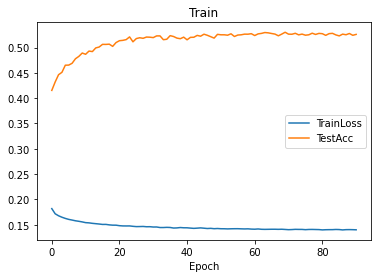

In [11]:
# plot the result
import matplotlib.pyplot as plt
%matplotlib inline

data = session.get_evaluation_data()
x_axis = [i for i in range(len(data))]
train_loss = [i[0] for i in data]
test_acc = [i[3] for i in data]

plt.plot(x_axis, train_loss, label="TrainLoss")
plt.plot(x_axis, test_acc, label="TestAcc")
plt.title("Train")
plt.xlabel("Epoch")
plt.legend()